In [1]:
!pip install Pillow
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 6 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,170 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [6]:
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import cv2
import time

In [4]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [7]:
#reading test image
image_BGR = cv2.imread('/content/car_2.jpg')

print('Image shape:', image_BGR.shape) 

h, w = image_BGR.shape[:2]  

print('Image height={0} and width={1}'.format(h, w))  # 511 767

Image shape: (445, 750, 3)
Image height=445 and width=750


In [8]:
#creating blob from image 
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416),
                             swapRB=True, crop=False)

print('Image shape:', image_BGR.shape)  
print('Blob shape:', blob.shape)

Image shape: (445, 750, 3)
Blob shape: (1, 3, 416, 416)


In [9]:
#reading class names from coco.names 
with open('/content/coco.names') as f:
    labels = [line.strip() for line in f]
    
print('List with labels names:')
print(labels)

List with labels names:
['Traffic sign', 'Vehicle registration plate']


In [10]:
#loading the cfg file and trained yolo weights
network = cv2.dnn.readNetFromDarknet('/content/yolov3.cfg',
                                     '/content/gdrive/My Drive/Collab Rough Work/yolov3_last.weights')

In [11]:
#get all the network layers
layers_names_all = network.getLayerNames()
print(layers_names_all)

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [12]:
#get the 3 output layers 
layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]
print(layers_names_output)  

['yolo_82', 'yolo_94', 'yolo_106']


In [13]:
#set probability minimum value
probability_minimum = 0.5
#set threshold value
threshold = 0.3
#select random colors for different objects
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

Text(0.5, 1.0, 'Test Image with Bounding Box Prediction')

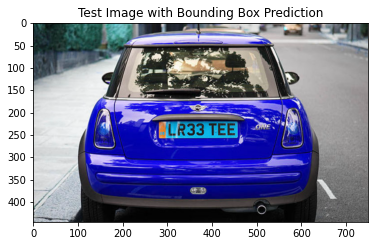

In [14]:
#test
plt.imshow(image_BGR)
plt.title('Test Image with Bounding Box Prediction')

In [15]:
 # setting blob as input to the network
network.setInput(blob) 
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

print('Objects Detection took {:.5f} seconds'.format(end - start))

bounding_boxes = []
confidences = []
class_numbers = []


for result in output_from_network:
    for detected_objects in result:
        scores = detected_objects[5:]
        class_current = np.argmax(scores)
        confidence_current = scores[class_current]

        # Eliminating weak predictions with minimum probability
        if confidence_current > probability_minimum:
           
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,
                           probability_minimum, threshold)


counter = 1
if len(results) > 0:
    for i in results.flatten():
        print('Object {0}: {1}'.format(counter, labels[int(class_numbers[i])]))

        # Incrementing counter
        counter += 1

        # Getting current bounding box coordinates,
        # its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        # and converting from numpy array to list
        colour_box_current = colours[class_numbers[i]].tolist()

        # Drawing bounding box on the original image
        cv2.rectangle(image_BGR, (x_min, y_min),
                      (x_min + box_width, y_min + box_height),
                      colour_box_current, 2)


        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                               confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_BGR, text_box_current, (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)


# Comparing how many objects where before non-maximum suppression
# and left after
print('Total objects been detected:', len(bounding_boxes))
print('Number of objects left after non-maximum suppression:', counter - 1)

Objects Detection took 2.60450 seconds
Object 1: Vehicle registration plate
Total objects been detected: 1
Number of objects left after non-maximum suppression: 1


Text(0.5, 1.0, 'Test Image with Bounding Box Prediction')

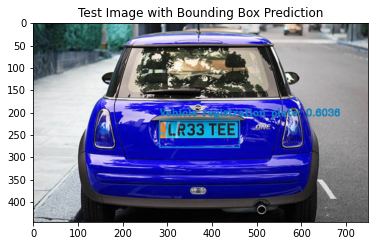

In [16]:
#test
plt.imshow(image_BGR)
plt.title('Test Image with Bounding Box Prediction')

In [17]:
#save cropped images
%cd /content/
def get_cropped_images(image_BGR_1):    
    counter = 1
    if len(results) > 0:
        for i in results.flatten():
            print('Object {0}: {1}'.format(counter, labels[int(class_numbers[i])]))

            # Incrementing counter
            counter += 1
            # Getting current bounding box coordinates,
            # its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            if counter==2:
                path=os.getcwd()
                os.makedirs(path+str('//crop'))
                os.chdir(path+str('//crop//'))
            else:
                pass

            crop_image=image_BGR_1[y_min:y_min+box_height,x_min:x_min+box_width]
            class_=str(labels[int(class_numbers[i])])
            rand=str(random.randint(0,1400000))
            name=class_+'_'+rand+'.jpg'
            print(name)
            plt.imsave(name, crop_image)

get_cropped_images(image_BGR)

/content
Object 1: Vehicle registration plate
Vehicle registration plate_124548.jpg


/content


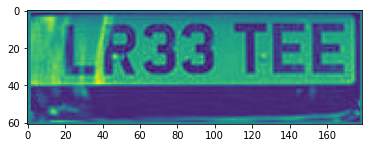

In [29]:
%cd /content/crop/
image=cv2.imread('Vehicle registration plate_124548.jpg',1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imsave('processed_image.jpg',gray)
plt.imshow(gray)

In [34]:
text = pytesseract.image_to_string(Image.open('Vehicle registration plate_124548.jpg'))
print(text)

R33 TEE

 

